In [1]:
import numpy as np
import scipy.signal as sg

import matplotlib.pyplot as plt
%matplotlib widget

In [11]:
path = '/home/lorenzo/phd/LQG/Experiments/SplitConvergence'

ms = [5.0, 7.0, 8.0, 9.0, 10.0, 20.0]
#dxs = [0.01, 0.005, 0.0025]
dx = 0.005

In [3]:
# B = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/B.dat',     skiprows=sr, max_rows=mr)
# E = np.loadtxt(path + f'/m{ms[0]}_dx{dx}_xMax70.0/outputs/E.dat',     skiprows=sr, max_rows=mr)

In [4]:
sr = 1000
mr = 8000

skipped = 10


main_peak = {}
second_peak = {}

for m in ms:

    p1 = []
    p2 = []

    x = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/xs.dat')
    r = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/rho.dat',   skiprows=sr, max_rows=mr)
    t = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/times.dat', skiprows=sr, max_rows=mr)

    for idx in range(len(r)):
        idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)

        if len(idx_MAX[0]) == 1:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]][0], skipped+idx_MAX[0][0]])
            p2.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX[0])  == 2:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0][1]], skipped+idx_MAX[0][1]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[0][0]], skipped+idx_MAX[0][0]])
        else:
            pass
            # print("too many peaks!")

    main_peak[m]   = np.array(p1)
    second_peak[m] = np.array(p2)

# t_main = np.array(main_peak[:,0]  )
# t_seco = np.array(second_peak[:,0])
# p_main = np.array(main_peak[:,1]  )
# p_seco = np.array(second_peak[:,1])
# peak_idx_main = np.array(main_peak[:,2], dtype = int)
# peak_idx_seco = np.array(second_peak[:,2], dtype = int)

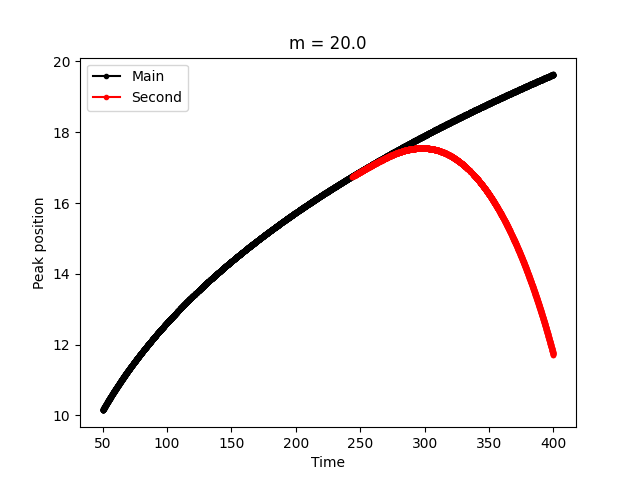

In [5]:
fig = plt.figure()

id = ms[-1]

plt.plot(main_peak[id][:,0], main_peak[id][:,1], '.-', color = 'k', label = 'Main')
plt.plot(second_peak[id][:,0], second_peak[id][:,1], '.-', color = 'r', label = 'Second')

plt.xlabel("Time")
plt.ylabel("Peak position")

plt.title(f'm = {id}')
plt.legend()

The fact that the position is piecewise constant tells me that the time step dt can be increased by a lot, since most of the timesteps are spent trying to resolve a movement much smaller then the grid. This would also speed up the simulations!

If such a small dt is needed for stability it is possible to reduce the number of time the output is saved, saving disk space.

In [6]:
first_index = []
peak_pos = []
time_pos = []

for id in ms:
    for i in range(len(second_peak[id][:,1])):
        if not np.isnan(second_peak[id][i,1]):
            print(f'm = {id}; time = {second_peak[id][i,0]}, position = {second_peak[id][i,1]}, index = {i}')
            first_index.append(i)
            peak_pos.append(second_peak[id][i,1])
            time_pos.append(second_peak[id][i,0])
            break

m = 5.0; time = 87.25005000233463, position = 7.4350005, index = 746
m = 7.0; time = 111.90005000315293, position = 9.0650005, index = 1239
m = 8.0; time = 123.55005000353967, position = 9.8050005, index = 1471
m = 9.0; time = 134.80005000198042, position = 10.505000500000001, index = 1697
m = 10.0; time = 145.85004999920665, position = 11.175000500000001, index = 1918
m = 20.0; time = 243.7000499746443, position = 16.7400005, index = 3875


Linear best fit parameters: (0.603 +- 0.026) x + (4.859 +- 0.282)
Quadratic best fit parameters: (-0.013 +- 0.001) x^2 + (0.945 +- 0.017) x + (3.057 +- 0.094)



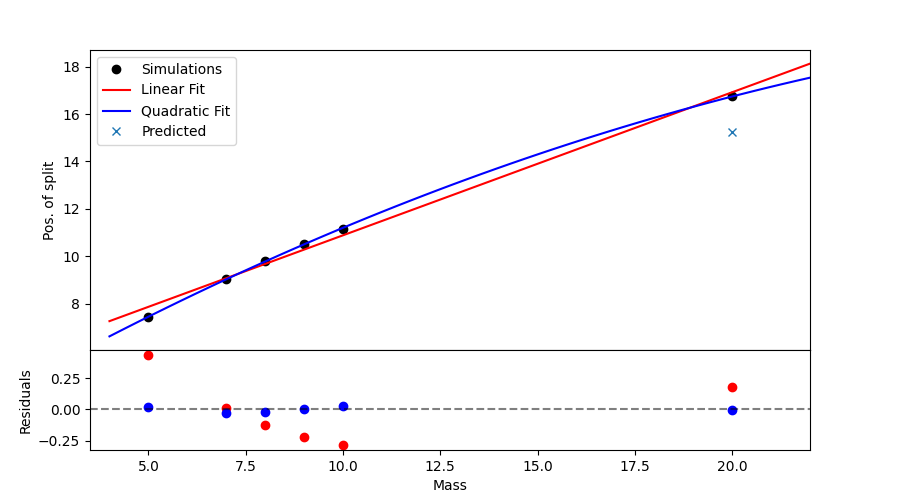

In [23]:
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a*x + b
def quad(x, a, b, c):
    return a*x**2 + b*x + c

peak_pos = np.array(peak_pos)
ms = np.array(ms)

lopt, lcov = curve_fit(lin, ms, peak_pos)
qopt, qcov = curve_fit(quad, ms, peak_pos)
mm = np.linspace(0.8*ms[0], 1.1*ms[-1])

fig = plt.figure(figsize=(9,5))
frame1=fig.add_axes((.1,.3,.8,.6))

plt.plot(ms, peak_pos,   'o', color = 'k', label = 'Simulations')
plt.plot(mm, lin(mm, *lopt) , color = 'r', label = 'Linear Fit')
plt.plot(mm, quad(mm, *qopt), color = 'b', label = 'Quadratic Fit')

plt.plot([20, 40], [15.226,20.156], 'x', label = 'Predicted')

plt.ylabel('Pos. of split')

plt.xlim(0.7*ms[0], 1.1*ms[-1])

plt.xticks([])
plt.legend()

frame2=fig.add_axes((.1,.1,.8,.2))

plt.axhline(0, ls = '--', color = 'k', alpha = 0.5)
plt.scatter(ms, lin(ms, *lopt) - peak_pos,  color = 'r')
plt.scatter(ms, quad(ms, *qopt) - peak_pos, color = 'b')

plt.xlabel('Mass')
plt.ylabel('Residuals')

plt.xlim(0.7*ms[0], 1.1*ms[-1])

s_lcov = np.round(np.sqrt(np.diagonal(lcov)), 3)
s_qcov = np.round(np.sqrt(np.diagonal(qcov)), 3)

text_lin = f"Linear best fit parameters: ({np.round(lopt[0],3)} +- {s_lcov[0]}) x + ({np.round(lopt[1],3)} +- {s_lcov[1]})"
text_quad = f"Quadratic best fit parameters: ({np.round(qopt[0],3)} +- {s_qcov[0]}) x^2 + ({np.round(qopt[1],3)} +- {s_qcov[1]}) x + ({np.round(qopt[2],3)} +- {s_qcov[2]})"

print(text_lin)
print(text_quad)
print()

# def Rsquared(fun, ms, peak_pos, par):
#     return 1 - np.sum(np.power(fun(ms, *par) - peak_pos, 2)) / np.sum(np.power(peak_pos, 2) - np.mean(peak_pos))

# R2_lin = Rsquared(lin, ms, peak_pos, lopt)
# R2_quad = Rsquared(quad, ms, peak_pos, qopt)

# print(f"R^2 linear fit: {R2_lin}")
# print(f"R^2 quadratic fit: {R2_quad}")

In [25]:
quad(40, *qopt)

20.156158043597493